In [13]:
import pickle
import patsy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report, make_scorer, fbeta_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Subset answer_time_series to include only top answerers (Avg 2 answers monthly)

In [10]:
with open('./data/processed/answer_time_series_3years_all.pkl', 'rb') as picklefile:
    answer_time_series_3years_all = pickle.load(picklefile)
with open('./data/processed/question_time_series_3years_all.pkl', 'rb') as picklefile:
    question_time_series_3years_all = pickle.load(picklefile)
with open('./data/processed/comment_time_series_3years_all.pkl', 'rb') as picklefile:
    comment_time_series_3years_all = pickle.load(picklefile)

In [17]:
def setMinAnswer(signupmonth, year_start, year_end):
    if ((signupmonth//100) < year_start):
        return (year_end-year_start+1)*24
    else:
        return (year_end-(signupmonth//100))*24 + (12-(signupmonth%100))*2
def extractTopAnswerer(df_ts, year_start, year_end):
    top_answerer = deepcopy(df_ts)
    top_answerer['min_answer'] = top_answerer.apply(lambda row:setMinAnswer(row[-1], year_start, year_end), axis=1)
    top_answerer_index = top_answerer.iloc[:,:-2].sum(axis=1) > top_answerer.min_answer
    top_answerer = top_answerer[top_answerer_index]
    top_answerer.drop('min_answer', inplace=True, axis=1)
    return top_answerer, top_answerer_index

In [23]:
top_answerer, top_answerer_idx = extractTopAnswerer(answer_time_series_3years_all, 2015, 2017)

In [24]:
top_answerer_question = question_time_series_3years_all[top_answerer_idx]
top_answerer_comment = comment_time_series_3years_all[top_answerer_idx]

In [29]:
with open('./data/processed/top_answerer_3year_all.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer, picklefile)
with open('./data/processed/top_answerer_question.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer_question, picklefile)
with open('./data/processed/top_answerer_comment.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer_comment, picklefile)

### Segment time series into 18 months, ignoring numbers before user signup

In [3]:
with open('./data/processed/top_answerer_3year_all.pkl', 'rb') as picklefile:
    top_answerer_3year_all = pickle.load(picklefile)
with open('./data/processed/top_answerer_question.pkl', 'rb') as picklefile:
    top_answerer_question = pickle.load(picklefile)
with open('./data/processed/top_answerer_comment.pkl', 'rb') as picklefile:
    top_answerer_comment = pickle.load(picklefile)

In [4]:
print (top_answerer_3year_all.shape)
print (top_answerer_question.shape)
print (top_answerer_comment.shape)

(18446, 37)
(18446, 37)
(18446, 37)


In [58]:
def monthsSince2015(signup_month):
    return ((signup_month//100)-2015)*12 + ((signup_month%100)-1)
df = deepcopy(top_answerer_3year_all)
df['cutoff'] = df.apply(lambda x:monthsSince2015(x[36]), axis=1)
keep_index =  df['cutoff']<=0
answers = top_answerer_3year_all[keep_index].iloc[:, 0:18]
answers.columns = ['ans-M', 'ans-M+1', 'ans-M+2', 'ans-M+3',
             'ans-M+4', 'ans-M+5', 'ans-M+6', 'ans-M+7',
             'ans-M+8', 'ans-M+9', 'ans-M+10', 'ans-M+11',
             'ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15',
             'ans-M+16', 'ans-M+17']

In [57]:
questions = top_answerer_question[keep_index].iloc[:,0:12]
questions.columns = ['qns-M', 'qns-M+1', 'qns-M+2', 'qns-M+3',
             'qns-M+4', 'qns-M+5', 'qns-M+6', 'qns-M+7',
             'qns-M+8', 'qns-M+9', 'qns-M+10', 'qns-M+11']
questions

,qns-M,qns-M+1,qns-M+2,qns-M+3,qns-M+4,qns-M+5,qns-M+6,qns-M+7,qns-M+8,qns-M+9,qns-M+10,qns-M+11
id,,,,,,,,,,,,
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
476,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
905,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
1026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [59]:
joint_data = pd.merge(questions, answers, how='left', left_index=True, right_index=True)

In [60]:
joint_data.head()

,qns-M,qns-M+1,qns-M+2,qns-M+3,qns-M+4,qns-M+5,qns-M+6,qns-M+7,qns-M+8,qns-M+9,...,ans-M+8,ans-M+9,ans-M+10,ans-M+11,ans-M+12,ans-M+13,ans-M+14,ans-M+15,ans-M+16,ans-M+17
id,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,12.0,21.0,3.0,0.0,25.0,19.0,9.0,7.0,21.0
267,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,17.0,29.0,15.0,22.0,26.0,19.0,8.0,18.0,22.0,25.0
369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,3.0,1.0,0.0,7.0,3.0,6.0,8.0,27.0,23.0
459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,2.0,0.0,1.0,1.0,0.0,6.0,14.0,5.0
476,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,77.0,63.0,35.0,55.0,60.0,93.0,80.0,57.0,29.0,50.0


In [42]:
comments = top_answerer_comment[keep_index].iloc[:,0:12].values

In [45]:
joint_data = np.concatenate((joint_data, comments), axis=1)

In [48]:
colnames = ['com-M', 'com-M+1', 'com-M+2', 'com-M+3',
             'com-M+4', 'com-M+5', 'com-M+6', 'com-M+7',
             'com-M+8', 'com-M+9', 'com-M+10', 'com-M+11',
             'qns-M', 'qns-M+1', 'qns-M+2', 'qns-M+3',
             'qns-M+4', 'qns-M+5', 'qns-M+6', 'qns-M+7',
             'qns-M+8', 'qns-M+9', 'qns-M+10', 'qns-M+11',
             'ans-M', 'ans-M+1', 'ans-M+2', 'ans-M+3',
             'ans-M+4', 'ans-M+5', 'ans-M+6', 'ans-M+7',
             'ans-M+8', 'ans-M+9', 'ans-M+10', 'ans-M+11',
             'ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15',
             'ans-M+16', 'ans-M+17']

In [49]:
test = pd.DataFrame(joint_data, columns=colnames)

In [63]:
print(test.shape)
test = pd.concat([test, test], axis=0)
test.shape

(26050, 42)


(52100, 42)

In [64]:
test.head()

,com-M,com-M+1,com-M+2,com-M+3,com-M+4,com-M+5,com-M+6,com-M+7,com-M+8,com-M+9,...,ans-M+8,ans-M+9,ans-M+10,ans-M+11,ans-M+12,ans-M+13,ans-M+14,ans-M+15,ans-M+16,ans-M+17
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.0,8.0,21.0,5.0,6.0,33.0,52.0,21.0,32.0,3.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,104.0,137.0,117.0,217.0,220.0,161.0,108.0,167.0,139.0,148.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,117.0,137.0,59.0,124.0,164.0,109.0,36.0,21.0,9.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,3.0,0.0,0.0,10.0,19.0,1.0,5.0,2.0,0.0
4,3.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,241.0,366.0,244.0,293.0,203.0,279.0,294.0,240.0,276.0,285.0


In [77]:
# Split data into many rows with 12 months' record, use the last n months to determine if user has churned
def monthsSince2015(signup_month):
    return ((signup_month//100)-2015)*12 + ((signup_month%100)-1)

def build_timeseries(df_answers, df_questions, df_comments, mode='convertEndStatus'):
    df = deepcopy(df_answers)
    df['cutoff'] = df.apply(lambda x:monthsSince2015(x[36]), axis=1)
    keep_index =  df['cutoff']<=0
    answers = df[keep_index].iloc[:, 0:18]
    answer_colnames = ['ans-M', 'ans-M+1', 'ans-M+2', 'ans-M+3',
             'ans-M+4', 'ans-M+5', 'ans-M+6', 'ans-M+7',
             'ans-M+8', 'ans-M+9', 'ans-M+10', 'ans-M+11',
             'ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15',
             'ans-M+16', 'ans-M+17']
    answers.columns = answer_colnames
    questions = df_questions[keep_index].iloc[:,0:12]
    question_colnames = ['qns-M', 'qns-M+1', 'qns-M+2', 'qns-M+3',
             'qns-M+4', 'qns-M+5', 'qns-M+6', 'qns-M+7',
             'qns-M+8', 'qns-M+9', 'qns-M+10', 'qns-M+11']
    questions.columns = question_colnames
    joint_data = pd.merge(questions, answers, how='left', left_index=True, right_index=True)
    comments = df_comments[keep_index].iloc[:,0:12]
    comment_colnames = ['com-M', 'com-M+1', 'com-M+2', 'com-M+3',
             'com-M+4', 'com-M+5', 'com-M+6', 'com-M+7',
             'com-M+8', 'com-M+9', 'com-M+10', 'com-M+11']
    comments.columns = comment_colnames
    joint_data = pd.merge(comments, joint_data, how='left', left_index=True, right_index=True)
    print ('round 0 - added', joint_data.shape[0], 'rows')
    
    for i in range(1, df_answers.shape[1] - 19):
        keep_index = df['cutoff']<=i
        answers = df[keep_index].iloc[:, i:i+18]
        answers.columns = answer_colnames
        questions = df_questions[keep_index].iloc[:,i:i+12]
        questions.columns = question_colnames
        extra_data = pd.merge(questions, answers, how='left', left_index=True, right_index=True)
        comments = df_comments[keep_index].iloc[:,i:i+12]
        comments.columns = comment_colnames
        extra_data = pd.merge(comments, extra_data, how='left', left_index=True, right_index=True)
        joint_data = pd.concat([joint_data, extra_data], axis=0)
        print ('round', i, '- added', extra_data.shape[0], 'rows')
        
    if (mode == 'convertEndStatus'):
        joint_data['inactive'] = joint_data.apply(lambda x:1 if np.sum(x[-6:])==0 else 0, axis=1)
    elif (mode == 'countLast6moAnswer'):
        joint_data['last6Month'] = joint_data.apply(lambda x:np.sum(x[-6:]), axis=1)
    joint_data.drop(['ans-M+12', 'ans-M+13','ans-M+14', 'ans-M+15', 'ans-M+16', 'ans-M+17'], inplace=True, axis=1)

    return joint_data

In [78]:
%time top_answerer = build_timeseries(top_answerer_3year_all, top_answerer_question, top_answerer_comment, 'convertEndStatus')

round 0 - added 13025 rows
(13025, 42)
(13300, 18)
(13300, 30)
(13300, 12)
(13300, 42)
round 1 - added 13300 rows
(13587, 18)
(13587, 30)
(13587, 12)
(13587, 42)
round 2 - added 13587 rows
(13920, 18)
(13920, 30)
(13920, 12)
(13920, 42)
round 3 - added 13920 rows
(14184, 18)
(14184, 30)
(14184, 12)
(14184, 42)
round 4 - added 14184 rows
(14491, 18)
(14491, 30)
(14491, 12)
(14491, 42)
round 5 - added 14491 rows
(14784, 18)
(14784, 30)
(14784, 12)
(14784, 42)
round 6 - added 14784 rows
(15094, 18)
(15094, 30)
(15094, 12)
(15094, 42)
round 7 - added 15094 rows
(15376, 18)
(15376, 30)
(15376, 12)
(15376, 42)
round 8 - added 15376 rows
(15681, 18)
(15681, 30)
(15681, 12)
(15681, 42)
round 9 - added 15681 rows
(15924, 18)
(15924, 30)
(15924, 12)
(15924, 42)
round 10 - added 15924 rows
(16192, 18)
(16192, 30)
(16192, 12)
(16192, 42)
round 11 - added 16192 rows
(16537, 18)
(16537, 30)
(16537, 12)
(16537, 42)
round 12 - added 16537 rows
(16866, 18)
(16866, 30)
(16866, 12)
(16866, 42)
round 13 -

In [82]:
with open('./data/processed/top_answerer.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer, picklefile)

In [2]:
with open('./data/processed/top_answerer.pkl', 'rb') as picklefile:
    top_answerer = pickle.load(picklefile)

## Merge the user demographic data with answer time series

In [3]:
with open('./data/processed/user_basic_processed.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)

In [4]:
user_basic.drop(['up_votes', 'down_votes'], axis=1, inplace=True)

In [5]:
top_answerer_basic = pd.merge(user_basic, top_answerer, how='right', left_index=True, right_index=True)

## Formalize X and Y

In [6]:
with open('./data/processed/location_dict.pkl', 'rb') as picklefile:
    location_dict = pickle.load(picklefile)

In [7]:
y = top_answerer_basic['inactive']
X = top_answerer_basic.drop('inactive', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4444, stratify=y)

In [8]:
## Dummify location
with open('./data/processed/location_dict.pkl', 'rb') as picklefile:
    location_dict = pickle.load(picklefile)
    
def map_dummify_Locations(df, location_dict):
    df['location'] = df.location.apply(lambda x:location_dict[x] if x in set(location_dict.keys()) else 'Others')
    location_dummy = patsy.dmatrix('location', data=df, return_type='dataframe')
    df = pd.concat([df, location_dummy], axis = 1)
    df.drop('location', axis=1, inplace=True)
    new_colnames = [item.replace('[','-') for item in list(df.columns)]
    new_colnames = [item.replace(']','') for item in new_colnames]
    df.columns = new_colnames
    df.drop('Intercept', axis=1, inplace=True)
    return df

In [9]:
X_train = map_dummify_Locations(X_train, location_dict)
X_test = map_dummify_Locations(X_test, location_dict)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
with open('./data/processed/X_train.pkl', 'wb') as picklefile:
    pickle.dump(X_train, picklefile)
with open('./data/processed/y_train.pkl', 'wb') as picklefile:
    pickle.dump(y_train, picklefile)
with open('./data/processed/X_test.pkl', 'wb') as picklefile:
    pickle.dump(X_test, picklefile)
with open('./data/processed/y_test.pkl', 'wb') as picklefile:
    pickle.dump(y_test, picklefile)

In [3]:
with open('./data/processed/X_train.pkl', 'rb') as picklefile:
    X_train = pickle.load(picklefile)
with open('./data/processed/y_train.pkl', 'rb') as picklefile:
    y_train = pickle.load(picklefile)
with open('./data/processed/X_test.pkl', 'rb') as picklefile:
    X_test = pickle.load(picklefile)
with open('./data/processed/y_test.pkl', 'rb') as picklefile:
    y_test = pickle.load(picklefile)

## Prepare data for training

In [4]:
# Normalize the data
ssX = StandardScaler()
X_train_norm = ssX.fit_transform(X_train)

In [5]:
np.sum(y_train == 1)/y_train.shape[0]

0.15039449274714467

In [6]:
X_train_resampled, y_train_resampled = RandomUnderSampler(random_state=4444).fit_sample(X_train_norm, y_train.ravel())

In [18]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy: {}".format(accuracy_score(y, dtrain_predictions)) )
    print ("AUC Score (Train): {}".format(roc_auc_score(y, dtrain_predprob)))
    
    if performCV:
        print (f"CV Score : Mean - {np.mean(cv_score)} | Std - {np.std(cv_score)} | Min - {np.min(cv_score)} | Max - {np.max(cv_score)}")
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy: 0.7938711211508739
AUC Score (Train): 0.8672639093059415
CV Score : Mean - 0.8625877257259266 | Std - 0.0017065672727549744 | Min - 0.8610578805511314 | Max - 0.8652423624222746


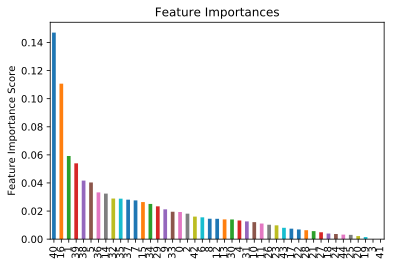

In [19]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train_resampled, y_train_resampled)

In [ ]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train_resampled, y_train_resampled)